In [1]:
!pip install transformers
!pip install gradio
!pip install timm
!pip install torchvision

/usr/bin/sh: 1: pip: not found
/usr/bin/sh: 1: pip: not found
/usr/bin/sh: 1: pip: not found
/usr/bin/sh: 1: pip: not found


In [2]:
from transformers.utils import logging
logging.set_verbosity_error()

### Mask Generation with SAM

The [Segment Anything Model (SAM)](https://segment-anything.com) model was released by Meta AI. Here we are using Segment Anything Model (SAM), it predicts pixel-wise labels for each pixel of the image with the corresponding label of the pixel. In segmentation mask generation, the difference is that users can perform what we call **visual prompting** by guiding the model on the location of the object of interest in order to predict the segmentation. So SAM, expects 2D points as an input but we can also give bounding boxes as inputs. Here the predicted mask won't have any label, the only label that we can extract from the mask is the the object corresponds to the object of interest that we have specifically selected.

In [3]:
from transformers import pipeline

In [4]:
sam_pipe = pipeline("mask-generation",
    "./models/Zigeng/SlimSAM-uniform-77")

Info about [Zigeng/SlimSAM-uniform-77](https://huggingface.co/Zigeng/SlimSAM-uniform-77)

In [5]:
from PIL import Image

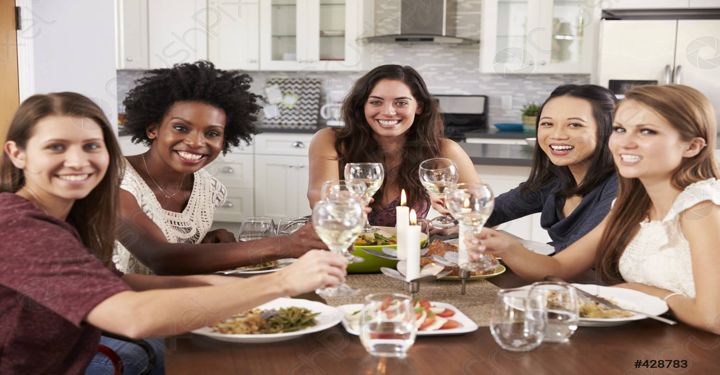

In [6]:
raw_image = Image.open('dinner.jpg')
raw_image.resize((720, 375))

- Running this will take some time
- The higher the value of 'points_per_batch', the more efficient pipeline inference for smaller hardware.

In [7]:
output = sam_pipe(raw_image, points_per_batch=32)

In [8]:
from helper import show_pipe_masks_on_image

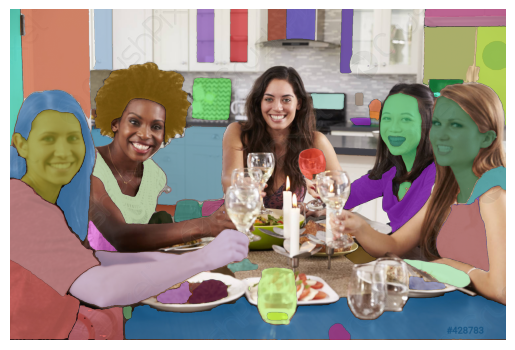

In [9]:
show_pipe_masks_on_image(raw_image, output)

The problem with this pipeline is that we need to iterate over all the points and post-process the generated masks which might be a bit slow for some use cases and applications. So we are going to focus on one specific use case where we were going to infer the model with an image and a single point.

### Faster Inference: Infer an Image and a Single Point

In [10]:
from transformers import SamModel, SamProcessor

In [11]:
model = SamModel.from_pretrained(
    "./models/Zigeng/SlimSAM-uniform-77")

processor = SamProcessor.from_pretrained(
    "./models/Zigeng/SlimSAM-uniform-77")

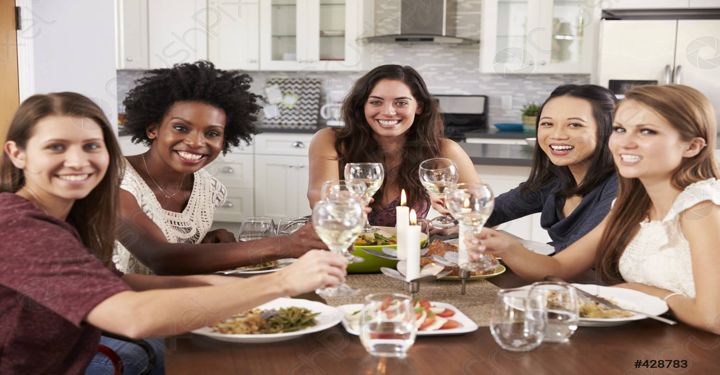

In [12]:
raw_image.resize((720, 375))

- Segment the girl sitting at the right most seat.
- Give any single 2D point that would be in that region.

In [13]:
input_points = [[[1600, 700]]]

- Create the input using the image and the single point.
- `return_tensors="pt"` means to return PyTorch Tensors.

In [14]:
inputs = processor(raw_image,
                 input_points=input_points,
                 return_tensors="pt")

- Given the inputs, get the output from the model.

In [15]:
import torch

In [16]:
with torch.no_grad():
    outputs = model(**inputs)

As we are going to perform a simple inference on the model with the `torch.no_grad()` context manager so that we make sure we do not compute the gradient.

In [17]:
predicted_masks = processor.image_processor.post_process_masks(
    outputs.pred_masks,
    inputs["original_sizes"],
    inputs["reshaped_input_sizes"]
)

 Length of `predicted_masks` corresponds to the number of images that are used in the input.

In [18]:
len(predicted_masks)

1

- Inspect the size of the first ([0]) predicted mask

In [19]:
predicted_mask = predicted_masks[0]
predicted_mask.shape

torch.Size([1, 3, 1000, 1500])

For our predicted mask we have a tensor of size 1, batch size of 3, and size of the image. To get the prediction scores we can use **iou_scores()** method.

In [20]:
outputs.iou_scores

tensor([[[0.8861, 0.8713, 0.5031]]])

In [21]:
from helper import show_mask_on_image

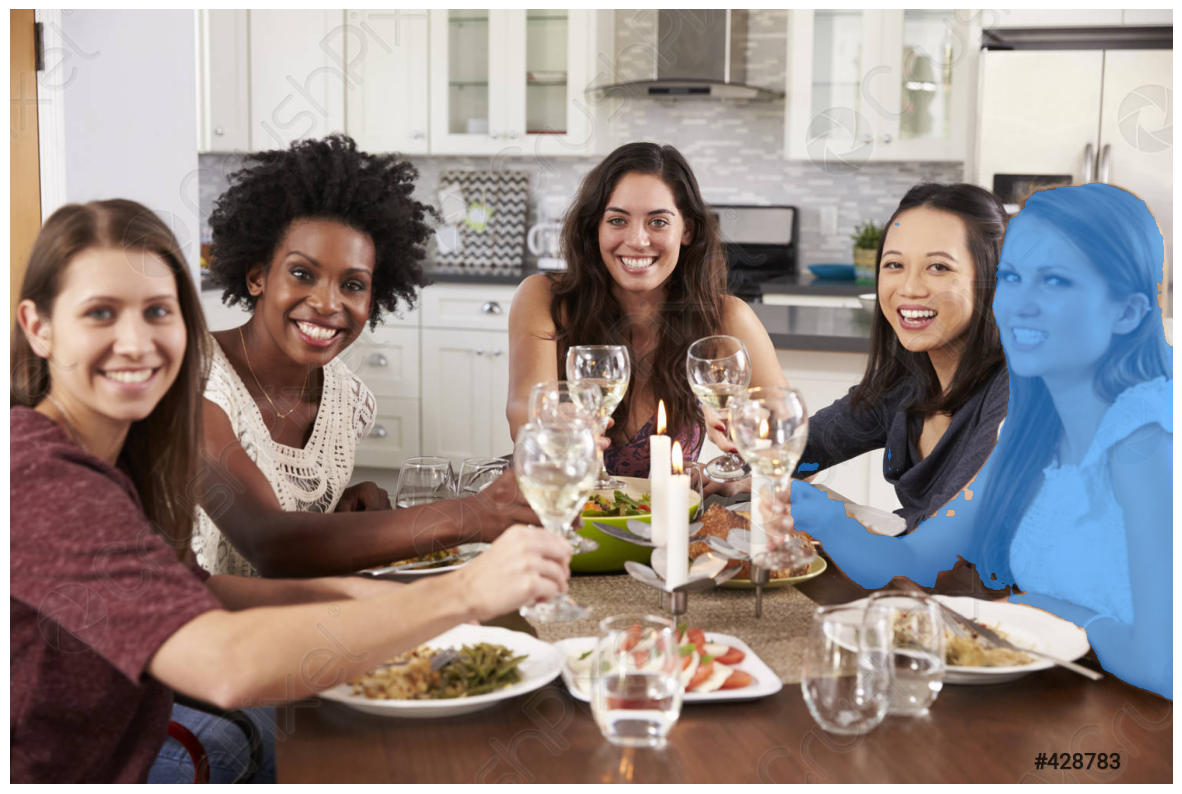

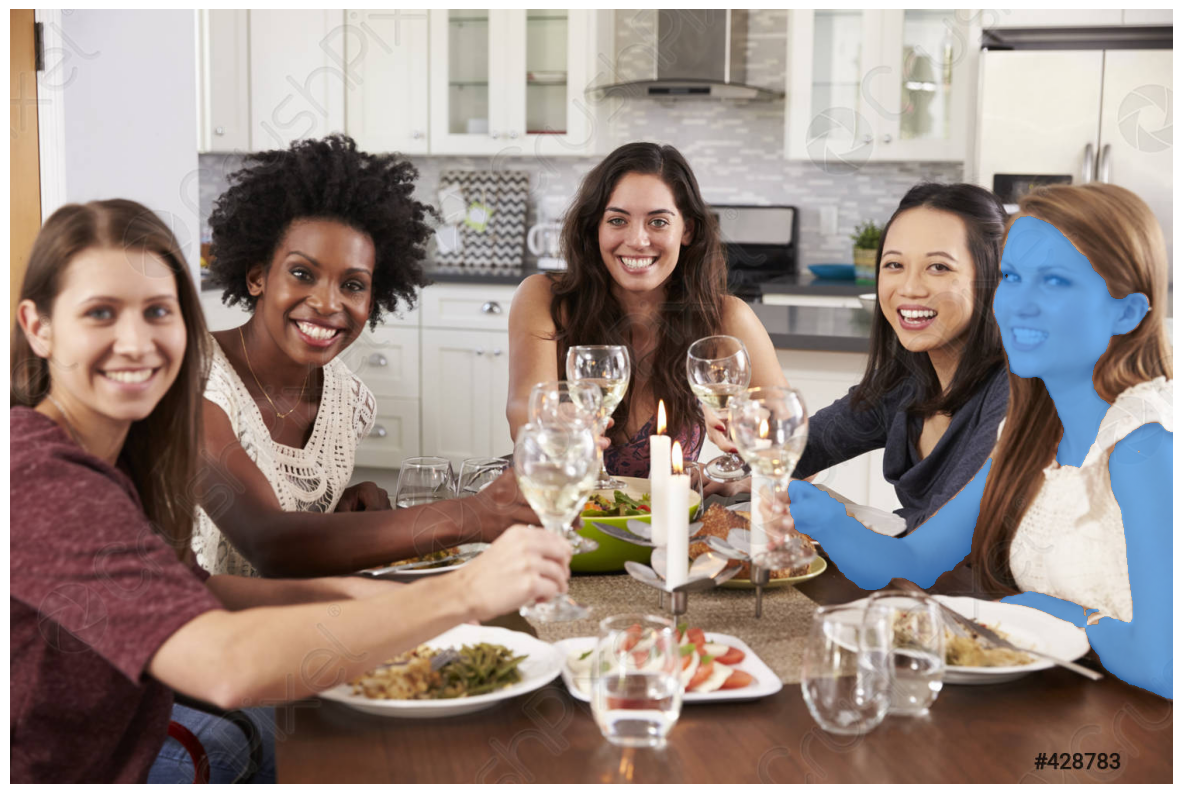

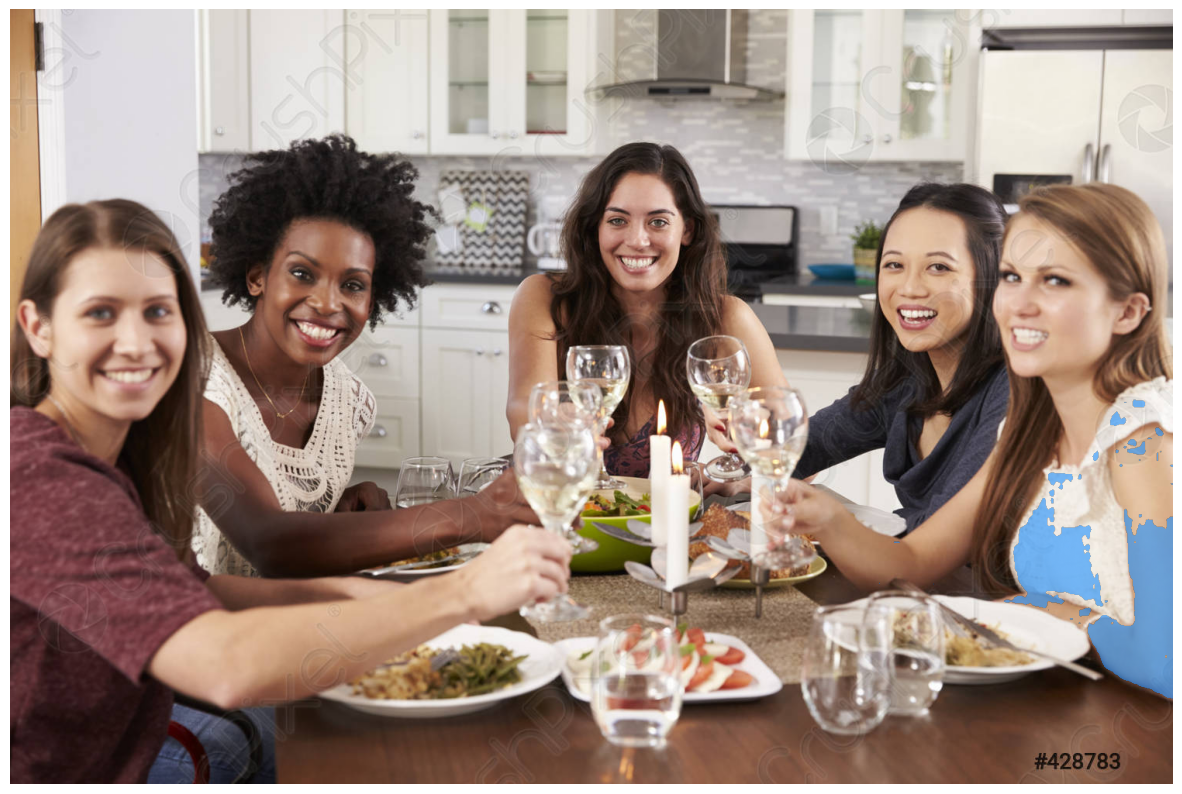

In [22]:
for i in range(3):
    show_mask_on_image(raw_image, predicted_mask[:, i])

## Depth Estimation with DPT

- This model was introduced in the paper [Vision Transformers for Dense Prediction](https://arxiv.org/abs/2103.13413) by Ranftl et al. (2021) and first released in [isl-org/DPT](https://github.com/isl-org/DPT).

In [23]:
depth_estimator = pipeline(task="depth-estimation",
                        model="./models/Intel/dpt-hybrid-midas")

Info about ['Intel/dpt-hybrid-midas'](https://huggingface.co/Intel/dpt-hybrid-midas)

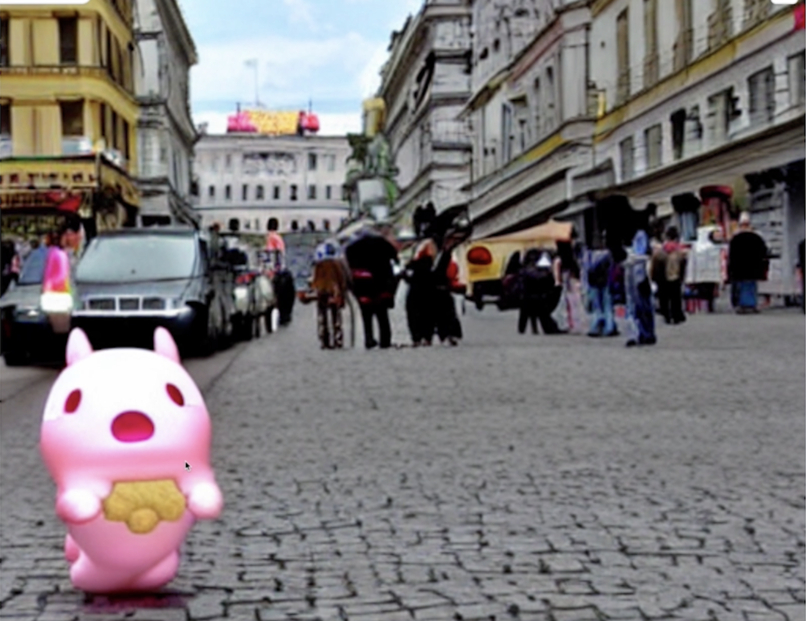

In [24]:
raw_image = Image.open('gradio_tamagochi_vienna.png')
raw_image.resize((806, 621))

- If you'd like to generate this image or something like it, check out the short course on [Gradio](https://www.deeplearning.ai/short-courses/building-generative-ai-applications-with-gradio/) and go to the lesson "Image Generation App".

In [25]:
output = depth_estimator(raw_image)

In [26]:
output

{'predicted_depth': tensor([[[ 248.4071,  252.1830,  256.9172,  ...,  595.8305,  591.8116,
            471.2303],
          [ 247.3372,  254.8538,  257.9681,  ...,  596.0256,  589.0461,
            594.1448],
          [ 259.7676,  259.5482,  261.4168,  ...,  597.6295,  595.3380,
            595.7502],
          ...,
          [3014.1089, 3018.4841, 3019.1711,  ..., 3275.2764, 3269.3469,
           3268.8364],
          [3041.5540, 3040.2783, 3044.4622,  ..., 3280.7478, 3289.3660,
           3274.8696],
          [3039.7480, 3056.0347, 3052.9739,  ..., 3301.9995, 3298.1880,
           3286.9133]]]),
 'depth': <PIL.Image.Image image mode=L size=1612x1242>}

- Post-process the output image to resize it to the size of the original image.

In [27]:
output["predicted_depth"].shape

torch.Size([1, 384, 384])

In [28]:
output["predicted_depth"].unsqueeze(1).shape

torch.Size([1, 1, 384, 384])

We have add another dimension via **unsqueeze()** method as the **interpolate()** method of PyTorch expects the number of channels.

In [29]:
prediction = torch.nn.functional.interpolate(
    output["predicted_depth"].unsqueeze(1),
    size=raw_image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

In [30]:
prediction.shape

torch.Size([1, 1, 1242, 1612])

In [31]:
raw_image.size[::-1],

((1242, 1612),)

In [32]:
prediction

tensor([[[[ 248.1578,  248.2615,  248.7577,  ...,  468.0634,  447.0041,
            442.8558],
          [ 248.0310,  248.1445,  248.6919,  ...,  477.7621,  458.3935,
            454.5775],
          [ 247.0837,  247.2387,  247.9994,  ...,  508.8539,  494.9505,
            492.2087],
          ...,
          [3040.0376, 3040.3977, 3042.2314,  ..., 3285.1282, 3283.1465,
           3282.7571],
          [3037.8701, 3038.3862, 3041.0276,  ..., 3288.0645, 3286.3359,
           3285.9915],
          [3037.5503, 3038.1130, 3040.9944,  ..., 3289.0696, 3287.3906,
           3287.0552]]]])

- Normalize the predicted tensors (between 0 and 255) so that they can be displayed.

In [33]:
import numpy as np 

In [34]:
output = prediction.squeeze().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

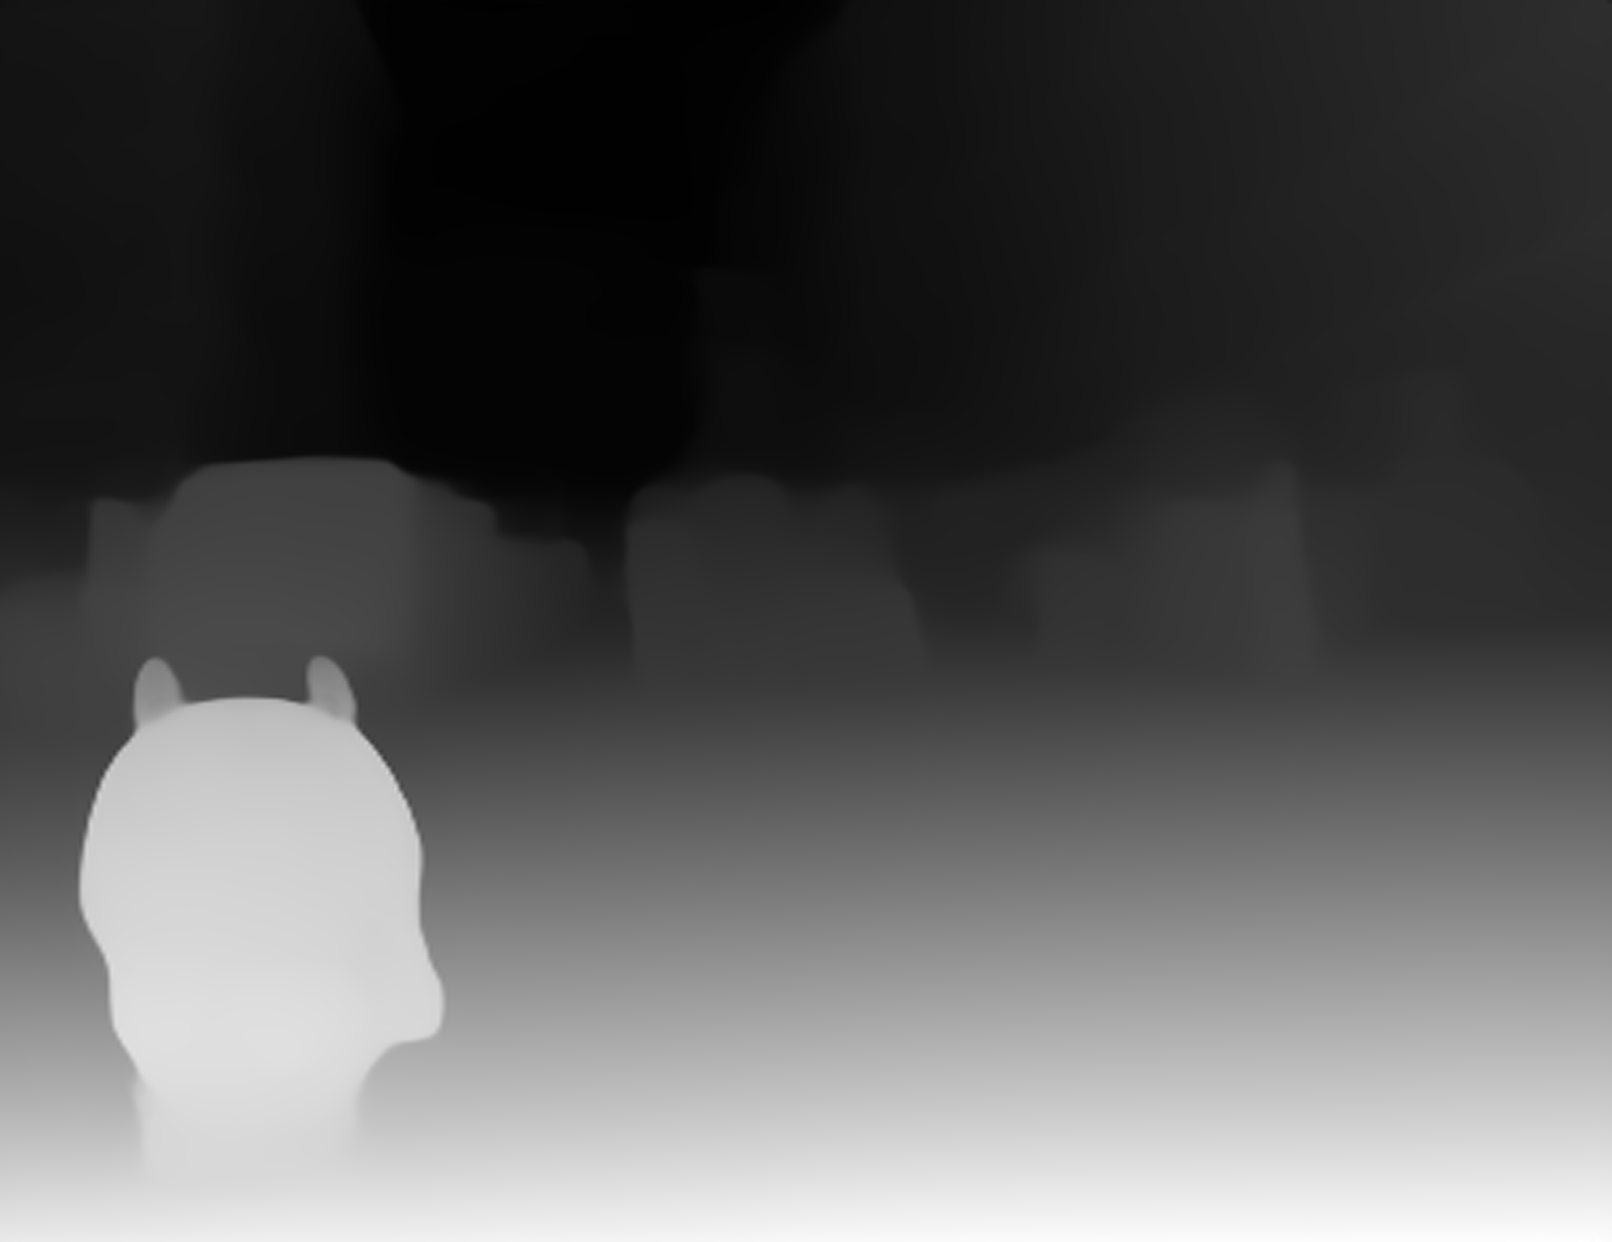

In [35]:
depth

Strong value towards white pixels means the object is very close to the image.

### Demo using Gradio

### Troubleshooting Tip
- Note, in the classroom, you may see the code for creating the Gradio app run indefinitely.
  - This is specific to this classroom environment when it's serving many learners at once, and you won't wouldn't experience this issue if you run this code on your own machine.
- To fix this, please restart the kernel (Menu Kernel->Restart Kernel) and re-run the code in the lab from the beginning of the lesson.

In [36]:
import os
import gradio as gr
from transformers import pipeline

In [37]:
def launch(input_image):
    out = depth_estimator(input_image)

    # resize the prediction
    prediction = torch.nn.functional.interpolate(
        out["predicted_depth"].unsqueeze(1),
        size=input_image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )

    # normalize the prediction
    output = prediction.squeeze().numpy()
    formatted = (output * 255 / np.max(output)).astype("uint8")
    depth = Image.fromarray(formatted)
    return depth

In [38]:
iface = gr.Interface(launch, 
                     inputs=gr.Image(type='pil'), 
                     outputs=gr.Image(type='pil'))

In [39]:
iface.launch(share=True, server_port=int(os.environ['PORT1']))

Running on local URL:  https://0.0.0.0:44111
Running on public URL: https://54213dc0715448b69f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [40]:
iface.close()

Closing server running on port: 44111
